In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [691 

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Yelp_NLP").getOrCreate()


In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.amazonaws.com/dataviz-curriculum/day_2/yelp_reviews.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("yelp_reviews.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+--------+--------------------+
|   class|                text|
+--------+--------------------+
|positive|Wow... Loved this...|
|negative|  Crust is not good.|
|negative|Not tasty and the...|
|positive|Stopped by during...|
|positive|The selection on ...|
|negative|Now I am getting ...|
|negative|Honeslty it didn'...|
|negative|The potatoes were...|
|positive|The fries were gr...|
|positive|      A great touch.|
|positive|Service was very ...|
|negative|  Would not go back.|
|negative|The cashier had n...|
|positive|I tried the Cape ...|
|negative|I was disgusted b...|
|negative|I was shocked bec...|
|positive| Highly recommended.|
|negative|Waitress was a li...|
|negative|This place is not...|
|negative|did not like at all.|
+--------+--------------------+
only showing top 20 rows



In [4]:
# Import functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

In [5]:
# create a new column that uses the length function to create a future feature with the length of each row

from pyspark.sql.functions import length
# Create a length column to be used as a future feature
data_df = df.withColumn('length', length(df['text']))
data_df.show()


+--------+--------------------+------+
|   class|                text|length|
+--------+--------------------+------+
|positive|Wow... Loved this...|    24|
|negative|  Crust is not good.|    18|
|negative|Not tasty and the...|    41|
|positive|Stopped by during...|    87|
|positive|The selection on ...|    59|
|negative|Now I am getting ...|    46|
|negative|Honeslty it didn'...|    37|
|negative|The potatoes were...|   111|
|positive|The fries were gr...|    25|
|positive|      A great touch.|    14|
|positive|Service was very ...|    24|
|negative|  Would not go back.|    18|
|negative|The cashier had n...|    99|
|positive|I tried the Cape ...|    59|
|negative|I was disgusted b...|    62|
|negative|I was shocked bec...|    50|
|positive| Highly recommended.|    19|
|negative|Waitress was a li...|    38|
|negative|This place is not...|    51|
|negative|did not like at all.|    20|
+--------+--------------------+------+
only showing top 20 rows



In [6]:
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [7]:
#create feature vector containing output from IDFModel andlength. combine all raw features to train ML model that we use
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')


In [8]:
# Create and run a data processing Pipeline, list of stages in order of execution
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [10]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)
cleaned.show()

+--------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|   class|                text|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|
+--------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|positive|Wow... Loved this...|    24|  1.0|[wow..., loved, t...|[wow..., loved, p...|(262144,[177414,2...|(262144,[177414,2...|(262145,[177414,2...|
|negative|  Crust is not good.|    18|  0.0|[crust, is, not, ...|      [crust, good.]|(262144,[49815,23...|(262144,[49815,23...|(262145,[49815,23...|
|negative|Not tasty and the...|    41|  0.0|[not, tasty, and,...|[tasty, texture, ...|(262144,[109649,1...|(262144,[109649,1...|(262145,[109649,1...|
|positive|Stopped by during...|    87|  1.0|[stopped, by, dur...|[stopped, late, m...|(262144,[53101

In [11]:
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3], 21)

In [12]:
from pyspark.ml.classification import NaiveBayes
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [13]:
#Once the model has been trained, we'll transform the model with our testing data
test_results = predictor.transform(testing)
test_results.show(5)

+--------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   class|                text|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|negative|"The burger... I ...|    86|  0.0|["the, burger...,...|["the, burger...,...|(262144,[20298,21...|(262144,[20298,21...|(262145,[20298,21...|[-820.60780566975...|[0.99999999999995...|       0.0|
|negative|              #NAME?|     6|  0.0|            [#name?]|            [#name?]|(262144,[197050],...|(262144,[197050],...|(262145,[197050,2...|[-73.489435340867...|[0.07515735596910.

In [19]:
x = test_results.select('label', 'prediction')
DF = x.toPandas()
DF.describe()

,label,prediction
count,328.000000,328.000000
mean,0.518293,0.365854
std,0.500429,0.482405
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


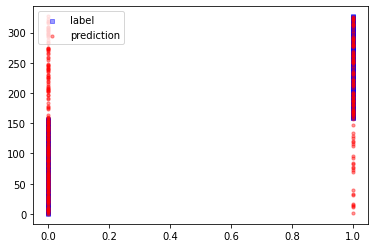

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(DF['label'], DF.index, s=10, c='b', marker="s", label='label', alpha = 0.4)
ax1.scatter(DF['prediction'],DF.index, s=10, c='r', marker="o", label='prediction', alpha = 0.4)
plt.legend(loc='upper left');
plt.show()

In [25]:
DF

,label,prediction
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
323,1.0,0.0
324,1.0,1.0
325,1.0,1.0
326,1.0,1.0


In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

acc_eval = BinaryClassificationEvaluator(labelCol = 'label', rawPredictionCol = 'prediction')
acc = acc_eval.evaluate(test_results)

print(f"Accuracy of model at predicting reviews was {acc} % ")

Accuracy of model at predicting reviews was 0.7002978406552495 % 
